#VGG16 모델을 사용하는 전이학습


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.datasets import cifar10

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [ ]:
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)

In [ ]:
#스케일링
X_train = X_train / 255.
X_test = X_test / 255.
X_val = X_val / 255.
#타겟 원핫인코딩
from keras.utils import to_categorical
Y_train_o = to_categorical(Y_train)
Y_val_o = to_categorical(Y_val)
Y_test_o = to_categorical(Y_test)

In [ ]:
X_train = X_train.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)
X_val = X_val.reshape(-1, 32, 32, 3)

In [ ]:
X_train.shape

(40000, 32, 32, 3)

In [ ]:
Y_train.shape

(40000,)

In [ ]:
from keras.applications import VGG16

In [ ]:
base = VGG16(
    include_top = False, # 전이학습을 하겠다. /분류기는 안가져옴
    input_shape = (32,32,3) # 전이학습
)

base.trainable = False # 학습을 안시키겠다.
base.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [ ]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    base,#Transfer Learing
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(units = 10, activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 14,781,642
Trainable params: 66,954
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
Adam = keras.optimizers.Adam(learning_rate =0.005)
model.compile(
    optimizer = Adam,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
ES = EarlyStopping(monitor = 'val_loss', patience = 3) #3번 안좋아지면 그만두겠다
ckpt = './ckpt/CNN3.ckpt'
mck = ModelCheckpoint(ckpt, monitor = 'val_loss',
                      save_weights_only = True,
                      save_best_only = True,
                      verbose = 1)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
Epochs = 50
Batch_size = 512

history = model.fit(
    X_train, Y_train_o,
    epochs = Epochs,
    batch_size = Batch_size,
    validation_data = (X_val, Y_val_o),
    verbose = 1,
    callbacks = [ES,mck]
)

Epoch 1/50
76/79 [===========================>..] - ETA: 0s - loss: 1.6472 - accuracy: 0.4217
Epoch 1: val_loss improved from inf to 1.37021, saving model to ./ckpt/CNN3.ckpt
79/79 [==============================] - 3s 21ms/step - loss: 1.6434 - accuracy: 0.4233 - val_loss: 1.3702 - val_accuracy: 0.5286
Epoch 2/50
76/79 [===========================>..] - ETA: 0s - loss: 1.4724 - accuracy: 0.4829
Epoch 2: val_loss improved from 1.37021 to 1.31316, saving model to ./ckpt/CNN3.ckpt
79/79 [==============================] - 1s 15ms/step - loss: 1.4714 - accuracy: 0.4832 - val_loss: 1.3132 - val_accuracy: 0.5411
Epoch 3/50
76/79 [===========================>..] - ETA: 0s - loss: 1.4324 - accuracy: 0.4975
Epoch 3: val_loss improved from 1.31316 to 1.27481, saving model to ./ckpt/CNN3.ckpt
79/79 [==============================] - 1s 15ms/step - loss: 1.4317 - accuracy: 0.4979 - val_loss: 1.2748 - val_accuracy: 0.5621
Epoch 4/50
76/79 [===========================>..] - ETA: 0s - loss: 1.4027 - 

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch']=history.epoch

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')

    plt.legend()
    plt.show()

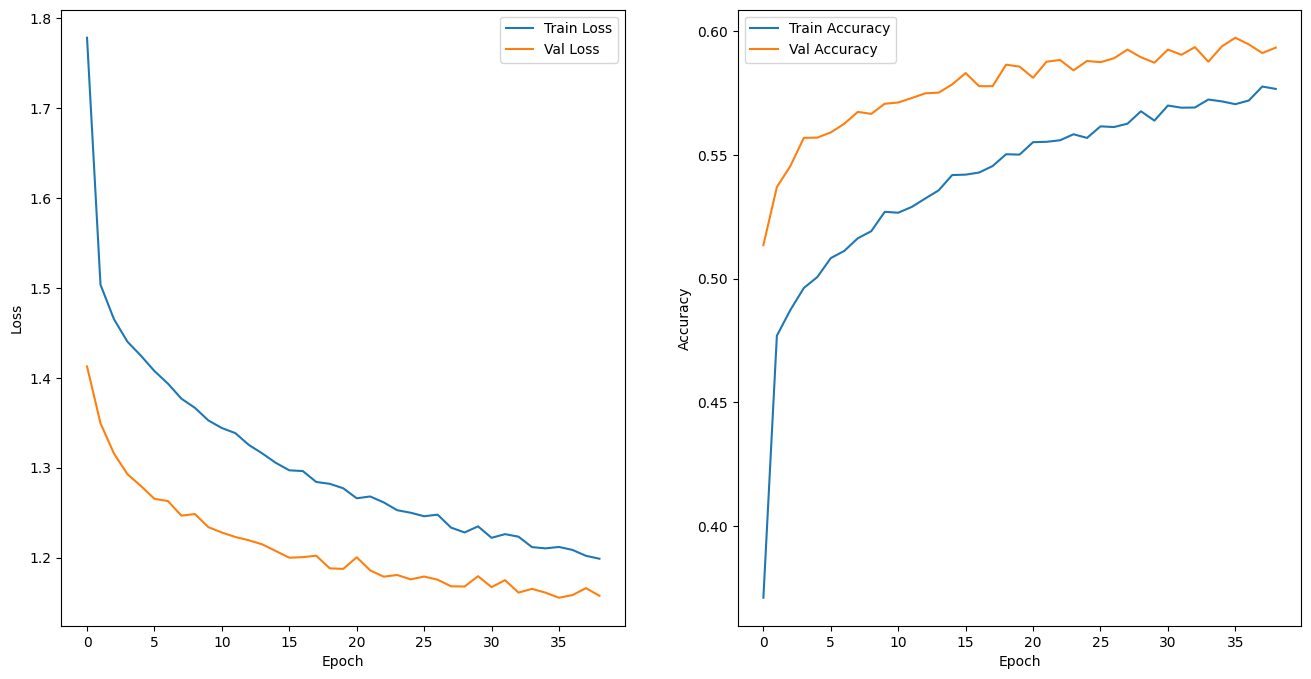

In [ ]:
plot_history(history)